In [8]:
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.io.wavfile import write, read
import math
from pychord import Chord
from pychord import find_chords_from_notes

In [9]:
def freq_to_note(freq):
    notes = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]

    A_freq = 440

    note_number = 12 * math.log2(freq / A_freq) + 49
    note_number = round(note_number)

    note_index = (note_number - 1) % len(notes)
    note = notes[note_index]

    octave = (note_number + 8) // len(notes)

    return list([note, octave, round(freq), note_index])


def right_rotate_list(list, n):
    for q in range(n):
        list.insert(0, list.pop())
    return list

In [10]:
fs = 44100  # Sample rate
seconds = 1

signal = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
sd.wait()

In [11]:
seconds = 6.7  # Duration of recording
a, signal = read(
    "./test_audio/cminor7.wav"
)  # C Db Bb G con C la nota di frequenza minore

# seconds = 18.559  # Duration of recording
# a, signal = read("./test_audio/dmajor.wav")


signal = (signal[:, 0] + signal[:, 1]) / 2  # Convert audio to mono
n_samples = signal.shape[0]
dT = seconds / n_samples  # Sample spacing

Remove first zero part

In [12]:
non_zero_find = False
j = 0

while j < len(signal) and not non_zero_find:
    if signal[0] == 0:
        j = j + 1
    else:
        non_zero_find = True


signal = signal[j:]

n_samples = len(signal)
seconds = dT * n_samples

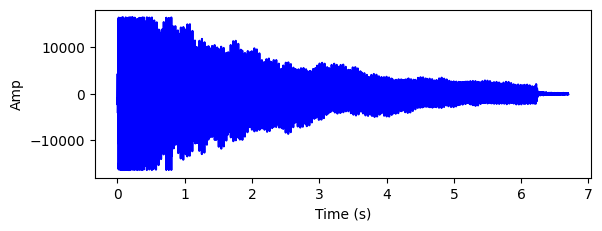

In [13]:
# plot signal versus time
t_array = np.linspace(0, seconds, n_samples)
plt.subplot(2, 1, 1)
plt.plot(t_array, signal, "b-")
plt.ylabel("Amp")
plt.xlabel("Time (s)")
plt.show()

FFT of the signal 

In [14]:
fft_signal = fft(signal)
fft_amp = np.abs(fft_signal)[: n_samples // 2]
fft_freq = fftfreq(n_samples, dT)[: n_samples // 2]

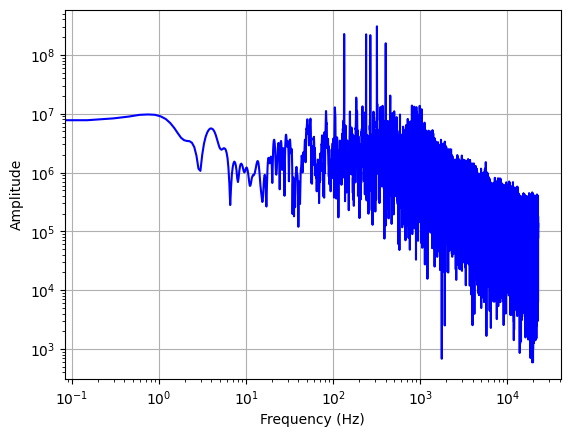

In [15]:
# plotting
fig, ax = plt.subplots()
plt.plot(fft_freq, fft_amp, "b-", label="Audio Signal")
ax.set_xscale("log")
ax.set_yscale("log")
plt.grid()
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.show()

Peak detection and notes search

In [16]:
n_peaks = 6  # Number of peak to detect
peak_size = 3  # Size in indexes of the peak

notes = []
# List of lists each of which:
# [0] note name
# [1] octave
# [2] frequency
# [3] note number in alphabetic order, starting from A
# [4] note amplitude in FFT

for i in range(0, n_peaks):
    max_index = np.argmax(fft_amp)
    max_amp = fft_amp[max_index]
    notes.append(freq_to_note(fft_freq[max_index]))
    notes[i].append(max_amp)
    fft_amp[max_index - peak_size : max_index + peak_size] = 0  # Remove peak

print(notes)

[['D#', 4, 319, 6, 305006369.0311944], ['C', 3, 134, 3, 225598748.25563875], ['A#', 3, 239, 1, 223057837.5710729], ['C', 4, 267, 3, 215908792.0710634], ['G', 4, 402, 10, 157022860.01558575], ['D#', 4, 319, 6, 61837593.47886044]]


Remove notes with amp way above the amp mean or impossible frequencies

In [17]:
min_freq = 15
max_freq = 8000

amp_lim = np.max(list(zip(*notes))[4]) * 0.2  # Lower amp lim

j = 1
for i in range(1, len(notes)):
    if (notes[j][4] < amp_lim) or (notes[j][2] < min_freq) or (notes[j][2] > max_freq):
        del notes[j]
    else:
        j = j + 1

print(notes)

[['D#', 4, 319, 6, 305006369.0311944], ['C', 3, 134, 3, 225598748.25563875], ['A#', 3, 239, 1, 223057837.5710729], ['C', 4, 267, 3, 215908792.0710634], ['G', 4, 402, 10, 157022860.01558575], ['D#', 4, 319, 6, 61837593.47886044]]


Sort notes base on alphabetic order and place root note on top

In [18]:
# Sort notes alphabetically
notes.sort(key=lambda a: a[3])

root_note_index = np.argmin(list(zip(*notes))[2])

if root_note_index != 0:
    notes = right_rotate_list(notes, len(notes) - root_note_index)

print(notes)

[['C', 3, 134, 3, 225598748.25563875], ['C', 4, 267, 3, 215908792.0710634], ['D#', 4, 319, 6, 305006369.0311944], ['D#', 4, 319, 6, 61837593.47886044], ['G', 4, 402, 10, 157022860.01558575], ['A#', 3, 239, 1, 223057837.5710729]]


Remove duplicated notes

In [19]:
last_note = notes[0][0]

j = 1
for i in range(1, len(notes)):
    if notes[j][0] == last_note:
        del notes[j]
    else:
        last_note = notes[j][0]
        j = j + 1

print(notes)

[['C', 3, 134, 3, 225598748.25563875], ['D#', 4, 319, 6, 305006369.0311944], ['G', 4, 402, 10, 157022860.01558575], ['A#', 3, 239, 1, 223057837.5710729]]


Find chords based on the finded notes

In [20]:
chords = find_chords_from_notes(list(zip(*notes))[0])
print(chords)

[<Chord: Cm7>, <Chord: D#6/C>]
